In [1]:
!pip install ta
#데이터셋을 만들어 주는 함수
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import LSTM,Dropout,GRU
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

df = pd.read_csv("./[금융]KB금융.csv")
df_columns = ['Date','Open', 'High', 'Low', 'Close', 'Volume']
df.columns = df_columns
df = df.sort_values('Date')
df['Date']= df['Date'].astype('str')
from datetime import datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)

ma = [5,20,60,120]
for days in ma:
    df['ma_'+str(days)] = df['Close'].rolling(window = days).mean()
    df['vma_'+str(days)] = df['Volume'].rolling(window = days).mean()

df.dropna(inplace=True)


import ta

H, L, C, V = df['High'], df['Low'], df['Close'], df['Volume']

# df['bol_high'] = ta.volatility.bollinger_hband(C)
# df['bol_low']  = ta.volatility.bollinger_lband(C)
df['MFI'] = ta.volume.money_flow_index(
    high=H, low=L, close=C, volume=V, fillna=True)

df['ADI'] = ta.volume.acc_dist_index(
    high=H, low=L, close=C, volume=V, fillna=True)

df['OBV'] = ta.volume.on_balance_volume(close=C, volume=V, fillna=True)
df['CMF'] = ta.volume.chaikin_money_flow(
    high=H, low=L, close=C, volume=V, fillna=True)

df['FI'] = ta.volume.force_index(close=C, volume=V, fillna=True)
df['EOM, EMV'] = ta.volume.ease_of_movement(
    high=H, low=L, volume=V, fillna=True)

df['VPT'] = ta.volume.volume_price_trend(close=C, volume=V, fillna=True)
df['NVI'] = ta.volume.negative_volume_index(close=C, volume=V, fillna=True)
df['VMAP'] = ta.volume.volume_weighted_average_price(
    high=H, low=L, close=C, volume=V, fillna=True)

# Volatility
df['ATR'] = ta.volatility.average_true_range(
    high=H, low=L, close=C, fillna=True)
df['BHB'] = ta.volatility.bollinger_hband(close=C, fillna=True)
df['BLB'] = ta.volatility.bollinger_lband(close=C, fillna=True)
df['KCH'] = ta.volatility.keltner_channel_hband(
    high=H, low=L, close=C, fillna=True)
df['KCL'] = ta.volatility.keltner_channel_lband(
    high=H, low=L, close=C, fillna=True)
df['KCM'] = ta.volatility.keltner_channel_mband(
    high=H, low=L, close=C, fillna=True)
df['DCH'] = ta.volatility.donchian_channel_hband(
    high=H, low=L, close=C, fillna=True)
df['DCL'] = ta.volatility.donchian_channel_lband(
    high=H, low=L, close=C, fillna=True)
df['DCM'] = ta.volatility.donchian_channel_mband(
    high=H, low=L, close=C, fillna=True)
df['UI'] = ta.volatility.ulcer_index(close=C, fillna=True)
# Trend
df['SMA'] = ta.trend.sma_indicator(close=C, fillna=True)
df['EMA'] = ta.trend.ema_indicator(close=C, fillna=True)
df['WMA'] = ta.trend.wma_indicator(close=C, fillna=True)
df['MACD'] = ta.trend.macd(close=C, fillna=True)
df['ADX'] = ta.trend.adx(high=H, low=L, close=C, fillna=True)
df['-VI'] = ta.trend.vortex_indicator_neg(
    high=H, low=L, close=C, fillna=True)
df['+VI'] = ta.trend.vortex_indicator_pos(
    high=H, low=L, close=C, fillna=True)
df['TRIX'] = ta.trend.trix(close=C, fillna=True)
df['MI'] = ta.trend.mass_index(high=H, low=L, fillna=True)
df['CCI'] = ta.trend.cci(high=H, low=L, close=C, fillna=True)
df['DPO'] = ta.trend.dpo(close=C, fillna=True)
df['KST'] = ta.trend.kst(close=C, fillna=True)
df['Ichimoku'] = ta.trend.ichimoku_a(high=H, low=L, fillna=True)
df['Parabolic SAR'] = ta.trend.psar_down(
    high=H, low=L, close=C, fillna=True)
df['STC'] = ta.trend.stc(close=C, fillna=True)
# Momentum
df['RSI'] = ta.momentum.rsi(close=C, fillna=True)
df['SRSI'] = ta.momentum.stochrsi(close=C, fillna=True)
df['TSI'] = ta.momentum.tsi(close=C, fillna=True)
df['UO'] = ta.momentum.ultimate_oscillator(
    high=H, low=L, close=C, fillna=True)
df['SR'] = ta.momentum.stoch(close=C, high=H, low=L, fillna=True)
df['WR'] = ta.momentum.williams_r(high=H, low=L, close=C, fillna=True)
df['AO'] = ta.momentum.awesome_oscillator(high=H, low=L, fillna=True)
df['KAMA'] = ta.momentum.kama(close=C, fillna=True)
df['ROC'] = ta.momentum.roc(close=C, fillna=True)
df['PPO'] = ta.momentum.ppo(close=C, fillna=True)
df['PVO'] = ta.momentum.pvo(volume=V, fillna=True)


from sklearn.preprocessing import MinMaxScaler

# 피처값 스케일링
scaler = MinMaxScaler()

scaled_df = scaler.fit_transform(df.drop(['Close'], axis=1))
scaled_df = pd.DataFrame(scaled_df, columns = df.drop(['Close'], axis=1).columns)

scaler1 = MinMaxScaler()

temp = scaler1.fit_transform(df['Close'].values.reshape(-1,1))

scaled_df.insert(3, 'Close',temp)
scaled_df

df = scaled_df



import numpy as np

def make_dataset(feature, label, window_size = 20):
  
  feature_list = []
  label_list = []
  
  for i in range(len(feature) - window_size) :
    feature_list.append(feature.iloc[i:i+window_size])
    label_list.append(label.iloc[i+window_size])
  
  return np.array(feature_list), np.array(label_list)

WINDOW_SIZE=20

result = []
predict = []


####최근 20개의 데이터만
pred_feature = df[-WINDOW_SIZE :]
pred_feature = pred_feature.to_numpy()

pred_feature = pred_feature.reshape((1,20,-1))
# pred_feature.shape

import random as rn
import tensorflow as tf


for i in range(1, len(df)//1000+2):

        # 데이터 불러오기
        df_copy = df
     
        # 원하는 크기로 데이터 자르기
        df_copy = df_copy[-i*1000:]
        # 피처값, 타켓 스케일링
        
        TEST_SIZE = int(len(df_copy) * 0.7)
        
        train = df_copy[:TEST_SIZE]
        test = df_copy[TEST_SIZE:]

##200일의 데이터를 얼마나 잘 예측하느냐
        
        # feature_cols = df.drop('Close', axis =1).columns
        feature_cols = df.columns
        label_cols = ['Close']

        train_feature = train[feature_cols]
        train_label = train[label_cols]

        train_feature, train_label = make_dataset(train_feature, train_label,20)

        from sklearn.model_selection import train_test_split
        x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2, shuffle = False)
        
        
        test_feature = test[feature_cols]
        test_label = test[label_cols]
        test_feature , test_label = make_dataset(test_feature, test_label,20)
        
        
        from keras.layers.normalization import batch_normalization

        model = Sequential()
        model.add(GRU(16, 
                      input_shape=(train_feature.shape[1], train_feature.shape[2]), 
                      return_sequences = False,
                      activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1))
      
        
        model.compile(loss='mean_squared_error', optimizer='adam')

        early_stop = EarlyStopping(monitor='val_loss', patience=10)

        import os
        from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

        model_path = 'model'
        filename = os.path.join(model_path, 'tmp_checkpoint.h5')
        checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

        history = model.fit(x_train, y_train, 
                                            epochs=100, 
                                            batch_size=16,
                                            validation_data=(x_valid, y_valid), 
                                            callbacks=[early_stop, checkpoint])


        pred = model.predict(test_feature)
        # rescaleing 작업
        rescaled_y_true = scaler1.inverse_transform(np.array(test_label).reshape(-1, 1))
        rescaled_pred = scaler1.inverse_transform(np.array(pred).reshape(-1,1))
        
        
        # 평가지표(RMSE) 계산
        RMSE = np.sqrt(mean_squared_error(rescaled_y_true, rescaled_pred))
        result.append(RMSE)
        print(f"{i * 1000}길이의 데이터 적용 완료\n 길이: {i * 1000}, RMSE:{RMSE}")
        print(result)
        

        new_pred = model.predict(pred_feature)
        rescaled_newpred = scaler1.inverse_transform(np.array(new_pred).reshape(-1,1))
        predict.append(rescaled_newpred)



C:\Users\gram\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\gram\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Epoch 1/100
30/34 [=========================>....] - ETA: 0s - loss: 0.0535
Epoch 1: val_loss improved from inf to 0.00871, saving model to model\tmp_checkpoint.h5
34/34 [==============================] - 2s 18ms/step - loss: 0.0498 - val_loss: 0.0087
Epoch 2/100
29/34 [========================>.....] - ETA: 0s - loss: 0.0241
Epoch 2: val_loss improved from 0.00871 to 0.00452, saving model to model\tmp_checkpoint.h5
34/34 [==============================] - 0s 8ms/step - loss: 0.0229 - val_loss: 0.0045
Epoch 3/100
28/34 [=======================>......] - ETA: 0s - loss: 0.0165
Epoch 3: val_loss improved from 0.00452 to 0.00352, saving model to model\tmp_checkpoint.h5
34/34 [==============================] - 0s 9ms/step - loss: 0.0161 - val_loss: 0.0035
Epoch 4/100
30/34 [=========================>....] - ETA: 0s - loss: 0.0115
Epoch 4: val_loss did not improve from 0.00352
34/34 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0080
Epoch 5/100
28/34 [=========

Epoch 9/100
100/104 [===========================>..] - ETA: 0s - loss: 0.0036
Epoch 9: val_loss improved from 0.00267 to 0.00146, saving model to model\tmp_checkpoint.h5
104/104 [==============================] - 1s 8ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 10/100
102/104 [============================>.] - ETA: 0s - loss: 0.0035
Epoch 10: val_loss did not improve from 0.00146
104/104 [==============================] - 1s 8ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 11/100
100/104 [===========================>..] - ETA: 0s - loss: 0.0028
Epoch 11: val_loss did not improve from 0.00146
104/104 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 12/100
104/104 [==============================] - ETA: 0s - loss: 0.0028
Epoch 12: val_loss did not improve from 0.00146
104/104 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 13/100
100/104 [===========================>..] - ETA: 0s - loss: 0.0027
Epoch 13: val

111/113 [============================>.] - ETA: 0s - loss: 0.0034
Epoch 13: val_loss improved from 0.00085 to 0.00082, saving model to model\tmp_checkpoint.h5
113/113 [==============================] - 1s 11ms/step - loss: 0.0034 - val_loss: 8.1661e-04
Epoch 14/100
107/113 [===========================>..] - ETA: 0s - loss: 0.0036
Epoch 14: val_loss improved from 0.00082 to 0.00071, saving model to model\tmp_checkpoint.h5
113/113 [==============================] - 1s 10ms/step - loss: 0.0036 - val_loss: 7.0569e-04
Epoch 15/100
111/113 [============================>.] - ETA: 0s - loss: 0.0035
Epoch 15: val_loss did not improve from 0.00071
113/113 [==============================] - 1s 10ms/step - loss: 0.0035 - val_loss: 7.6189e-04
Epoch 16/100
109/113 [===========================>..] - ETA: 0s - loss: 0.0032
Epoch 16: val_loss did not improve from 0.00071
113/113 [==============================] - 1s 10ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 17/100
112/113 [=====================

In [2]:
print(predict)

[array([[58167.246]], dtype=float32), array([[56538.48]], dtype=float32), array([[56906.35]], dtype=float32), array([[61390.863]], dtype=float32)]


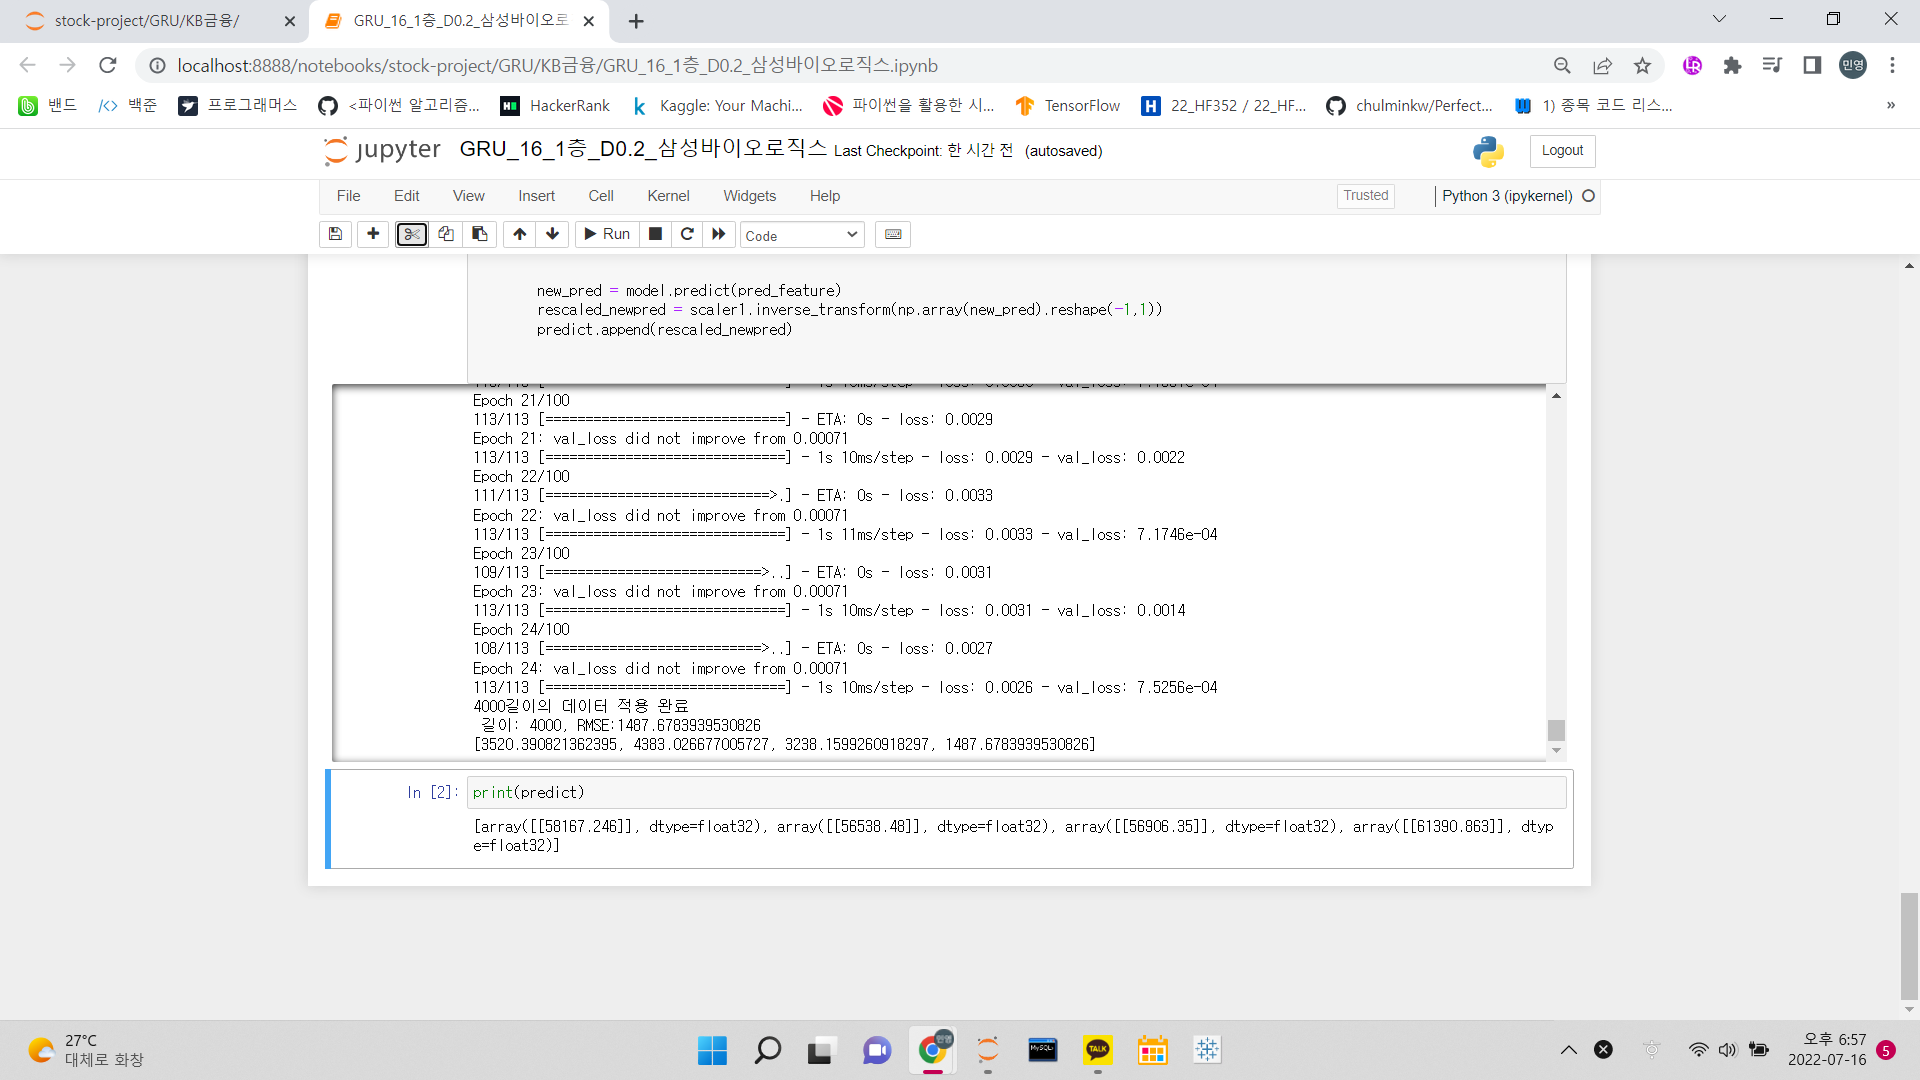